In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [16]:

kdd = pd.read_csv("kdd.csv")
nsl = pd.read_csv("nsl.csv")
ids = pd.read_csv("ids.csv")
ciciot = pd.read_csv("ciciot.csv")
kitsune = pd.read_csv("kitsune.csv")
credit = pd.read_csv("credit.csv")
ecg = pd.read_csv("ecg.csv")

in_kdd = kdd.loc[kdd['r1']==0.,'n1'].values[0]
in_ids = ids.loc[ids['r1']==0.,'n1'].values[0]
in_kitsune = kitsune.loc[kitsune['r1']==0.,'n1'].values[0]
in_ciciot = ciciot.loc[ciciot['r1']==0.,'n1'].values[0]
in_credit = credit.loc[credit['r1']==0.,'n1'].values[0]
in_ecg = ecg.loc[ecg['r1']==0.,'n1'].values[0]


kdd['ratio'] = kdd['n2']*(1-kdd['r2'])/in_kdd
ids['ratio'] = ids['n2']*(1-ids['r2'])/in_ids
ciciot['ratio'] = ciciot['n2']*(1-ciciot['r2'])/in_ciciot
kitsune['ratio'] = kitsune['n2']*(1-kitsune['r2'])/in_kitsune
credit['ratio'] = credit['n2']*(1-credit['r2'])/in_credit
nsl['ratio'] = nsl['n2']*(1-nsl['r2'])/in_kdd
ecg['ratio'] = ecg['n2']*(1-ecg['r2'])/in_ecg

kdd['name'] ='kdd'
nsl['name'] ='nsl'
credit['name'] ='credit'
ids['name'] = 'ids'
ciciot['name'] ='ciciot'
kitsune['name'] = 'kitsune'
ecg['name'] = 'ecg'
data = pd.concat([kdd, ids, ciciot,kitsune, credit, ecg], ignore_index=True)

In [17]:
ecg

,n1,n2,r1,r2,ratio,name
0,1247,1058,0.000000,0.000000,0.848436,ecg
1,1344,1135,0.072173,0.000000,0.910184,ecg
2,1441,1182,0.134629,0.027073,0.922213,ecg
3,1538,1185,0.189207,0.050633,0.902165,ecg
4,1635,1290,0.237309,0.123256,0.906977,ecg
5,1733,1429,0.280439,0.233730,0.878107,ecg
6,1830,1500,0.318579,0.278000,0.868484,ecg
7,1927,1610,0.352880,0.331677,0.862871,ecg
8,2024,1628,0.383893,0.363022,0.831596,ecg
9,2122,1759,0.412347,0.400796,0.845229,ecg


In [18]:
#data = data[data['name']!='ids']
#data = data[data['metric']=='sdc']
data.rename(columns={'name': 'dataset'}, inplace=True)
eps = 0.0000000000000001
data['improvement'] = 100*(data.r1-data.r2)/(data.r1+eps)
data['id'] = range(len(data))
data = data.sort_values(by=['dataset', 'r1'])
data.loc[data['dataset']=='kdd', 'id'] = range(10)
data.loc[data['dataset']=='ciciot', 'id'] = range(10)
data.loc[data['dataset']=='ids', 'id'] = range(10)
data.loc[data['dataset']=='kitsune', 'id'] = range(10)
data.loc[data['dataset']=='credit', 'id'] = range(10)
data.loc[data['dataset']=='ecg', 'id'] = range(10)
data.head(40)

,n1,n2,r1,r2,ratio,dataset,improvement,id
20,125032,116591,0.000000,0.000000,0.932489,ciciot,0.000000,0
21,129861,117147,0.037186,0.000000,0.936936,ciciot,100.000000,1
22,134690,120330,0.071705,0.005526,0.957075,ciciot,92.292813,2
23,139520,122387,0.103842,0.031882,0.947637,ciciot,69.297057,3
24,144349,123392,0.133822,0.049193,0.938336,ciciot,63.239976,4
25,149179,125353,0.161866,0.065447,0.936952,ciciot,59.567050,5
26,154008,125857,0.188146,0.085319,0.920716,ciciot,54.652759,6
27,158838,124562,0.212833,0.098433,0.898178,ciciot,53.751150,7
28,163667,130194,0.236059,0.111687,0.924987,ciciot,52.686671,8
29,168497,127797,0.257957,0.137625,0.881446,ciciot,46.648297,9


In [19]:
data[data['dataset']=='ecg'].head(40)

,n1,n2,r1,r2,ratio,dataset,improvement,id
50,1247,1058,0.000000,0.000000,0.848436,ecg,0.000000,0
51,1344,1135,0.072173,0.000000,0.910184,ecg,100.000000,1
52,1441,1182,0.134629,0.027073,0.922213,ecg,79.890802,2
53,1538,1185,0.189207,0.050633,0.902165,ecg,73.239375,3
54,1635,1290,0.237309,0.123256,0.906977,ecg,48.061017,4
55,1733,1429,0.280439,0.233730,0.878107,ecg,16.655579,5
56,1830,1500,0.318579,0.278000,0.868484,ecg,12.737564,6
57,1927,1610,0.352880,0.331677,0.862871,ecg,6.008586,7
58,2024,1628,0.383893,0.363022,0.831596,ecg,5.436711,8
59,2122,1759,0.412347,0.400796,0.845229,ecg,2.801267,9


In [20]:
data_cp = data.copy()
data_cp = data_cp[data_cp['r1'] != 0]
data_cp.head(40)

,n1,n2,r1,r2,ratio,dataset,improvement,id
21,129861,117147,0.037186,0.000000,0.936936,ciciot,100.000000,1
22,134690,120330,0.071705,0.005526,0.957075,ciciot,92.292813,2
23,139520,122387,0.103842,0.031882,0.947637,ciciot,69.297057,3
24,144349,123392,0.133822,0.049193,0.938336,ciciot,63.239976,4
25,149179,125353,0.161866,0.065447,0.936952,ciciot,59.567050,5
26,154008,125857,0.188146,0.085319,0.920716,ciciot,54.652759,6
27,158838,124562,0.212833,0.098433,0.898178,ciciot,53.751150,7
28,163667,130194,0.236059,0.111687,0.924987,ciciot,52.686671,8
29,168497,127797,0.257957,0.137625,0.881446,ciciot,46.648297,9
41,125488,117369,0.000128,0.000000,0.935420,credit,100.000000,1


In [24]:
data_cp[data_cp['dataset']=='ciciot'].head(40)

,n1,n2,r1,r2,ratio,dataset,improvement,id
21,129861,117147,0.037186,0.000000,0.936936,ciciot,100.000000,1
22,134690,120330,0.071705,0.005526,0.957075,ciciot,92.292813,2
23,139520,122387,0.103842,0.031882,0.947637,ciciot,69.297057,3
24,144349,123392,0.133822,0.049193,0.938336,ciciot,63.239976,4
25,149179,125353,0.161866,0.065447,0.936952,ciciot,59.567050,5
26,154008,125857,0.188146,0.085319,0.920716,ciciot,54.652759,6
27,158838,124562,0.212833,0.098433,0.898178,ciciot,53.751150,7
28,163667,130194,0.236059,0.111687,0.924987,ciciot,52.686671,8
29,168497,127797,0.257957,0.137625,0.881446,ciciot,46.648297,9


In [7]:
df_1 = pd.read_csv("performances_kdd_AE.csv")
df_2 = pd.read_csv("performances_kdd_OC-SVM.csv")
df_3 = pd.read_csv("performances_kdd_LOF.csv")
df_4 = pd.read_csv("performances_kdd_IF.csv")
df_5 = pd.read_csv("performances_kdd_svdd.csv")
df_6 = pd.read_csv("performances_kdd_dsebm.csv")
df_7 = pd.read_csv("performances_kdd_alad.csv")
df_8 = pd.read_csv("performances_kdd_dagmm.csv")
df_kdd = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [8]:
df_1 = pd.read_csv("performances_kitsune_AE.csv")
df_2 = pd.read_csv("performances_kitsune_OC-SVM.csv")
df_3 = pd.read_csv("performances_kitsune_LOF.csv")
df_4 = pd.read_csv("performances_kitsune_IF.csv")
df_5 = pd.read_csv("performances_kitsune_svdd.csv")
df_6 = pd.read_csv("performances_kitsune_dsebm.csv")
df_7 = pd.read_csv("performances_kitsune_alad.csv")
df_8 = pd.read_csv("performances_kitsune_dagmm.csv")
df_kitsune = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7,df_8], axis=0, ignore_index=True)

In [9]:
df_1 = pd.read_csv("performances_ciciot_AE.csv")
df_2 = pd.read_csv("performances_ciciot_OC-SVM.csv")
df_3 = pd.read_csv("performances_ciciot_LOF.csv")
df_4 = pd.read_csv("performances_ciciot_IF.csv")
df_5 = pd.read_csv("performances_ciciot_svdd.csv")
df_6 = pd.read_csv("performances_ciciot_dsebm.csv")
df_7 = pd.read_csv("performances_ciciot_alad.csv")
df_8 = pd.read_csv("performances_ciciot_dagmm.csv")
df_ciciot = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [10]:
df_1 = pd.read_csv("performances_ids_AE.csv")
df_2 = pd.read_csv("performances_ids_OC-SVM.csv")
df_3 = pd.read_csv("performances_ids_LOF.csv")
df_4 = pd.read_csv("performances_ids_IF.csv")
df_5 = pd.read_csv("performances_ids_svdd.csv")
df_6 = pd.read_csv("performances_ids_dsebm.csv")
df_7 = pd.read_csv("performances_ids_alad.csv")
df_8 = pd.read_csv("performances_ids_dagmm.csv")
df_ids = pd.concat([df_1, df_2,  df_3, df_4, df_5, df_6, df_7,df_8], axis=0, ignore_index=True)

In [11]:
df_1 = pd.read_csv("performances_ecg_AE.csv")
df_2 = pd.read_csv("performances_ecg_OC-SVM.csv")
df_3 = pd.read_csv("performances_ecg_LOF.csv")
df_4 = pd.read_csv("performances_ecg_IF.csv")
df_5 = pd.read_csv("performances_ecg_svdd.csv")
df_6 = pd.read_csv("performances_ecg_dsebm.csv")
df_7 = pd.read_csv("performances_ecg_alad.csv")
df_8 = pd.read_csv("performances_ecg_dagmm.csv")
df_ecg = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [12]:
df_1 = pd.read_csv("performances_credit_AE.csv")
df_2 = pd.read_csv("performances_credit_OC-SVM.csv")
df_3 = pd.read_csv("performances_credit_LOF.csv")
df_4 = pd.read_csv("performances_credit_IF.csv")
df_5 = pd.read_csv("performances_credit_svdd.csv")
df_6 = pd.read_csv("performances_credit_dsebm.csv")
df_7 = pd.read_csv("performances_credit_alad.csv")
df_8 = pd.read_csv("performances_credit_dagmm.csv")
df_credit = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [13]:
df_perf = pd.concat([df_kdd, df_kitsune, df_ciciot, df_ecg, df_ids, df_credit], axis=0, ignore_index=True)
df_perf = df_perf.sort_values(by='dataset')

In [14]:
df_perf[df_perf["model"]=="Bopeto_svdd"].head()

,dataset,contamination,model,accuracy,precision,recall,f1,Unnamed: 0
482,ciciot,0.254774,Bopeto_svdd,0.540319,0.701072,0.538368,0.609041,NaN
462,ciciot,0.000000,Bopeto_svdd,0.643638,0.788447,0.634383,0.703074,NaN
464,ciciot,0.033057,Bopeto_svdd,0.537701,0.698988,0.535477,0.606404,NaN
466,ciciot,0.063999,Bopeto_svdd,0.499876,0.666018,0.497464,0.569532,NaN
468,ciciot,0.093022,Bopeto_svdd,0.565008,0.720626,0.564964,0.633371,NaN


In [15]:
sub_df = df_perf[['dataset', 'contamination']].copy()
sub_df['contamination'] = sub_df['contamination']*100
sub_df = sub_df.drop_duplicates().groupby("dataset")['contamination'].apply(lambda x: sorted(x)).to_dict()

keys = list(sub_df.keys())
for key in keys:
    sub_df[key] = np.diff(sub_df[key])
contaminations = {}
size = len(sub_df["kitsune"])
for i in range(size):
    contaminations[i] = [sub_df["ciciot"][i], sub_df["credit"][i], sub_df["ecg"][i], 
           sub_df["ids"][i], sub_df["kdd"][i], sub_df["kitsune"][i]]
 

/tmp/ipykernel_109323/2709635439.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(keys, rotation=90)


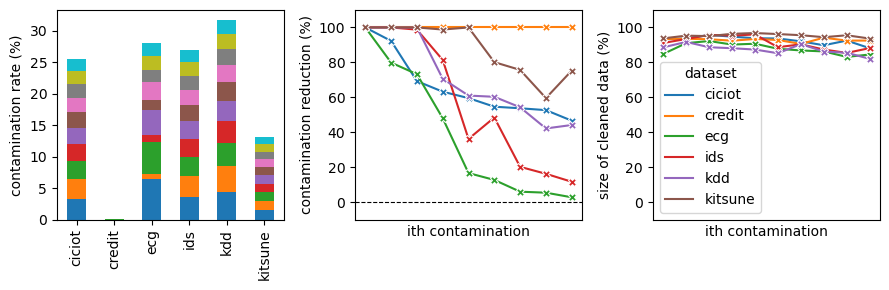

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
cond = data['dataset']=='ciciot'
width = 0.5
bottom = np.zeros(6) 
for boolean, weight_count in contaminations.items():
    p = ax[0].bar(keys, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
ax[0].set_ylabel('contamination rate (%)')
ax[0].legend().remove()
ax[0].set_xticklabels(keys, rotation=90)


sns.lineplot(data=data_cp, x=data_cp.id, y=data_cp.improvement, hue='dataset', ax=ax[1], marker='X')
#ax.set_title(f'{subplot}'.upper())
ax[1].set_xlabel('ith contamination') 
ax[2].set_ylabel('size of cleaned data (%)')
sns.lineplot(data=data, x=data.id, y=100*data.ratio, hue='dataset', ax=ax[2], marker='X')
ax[2].set_xlabel('ith contamination') 
ax[1].set_ylabel('contamination reduction (%)')
ax[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax[1].legend().remove()
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[1].set_ylim(-10, 110)
ax[2].set_ylim(-10, 110)
plt.tight_layout()
plt.savefig("cleaning_ratio.pdf")
plt.show()

/tmp/ipykernel_10041/491522319.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


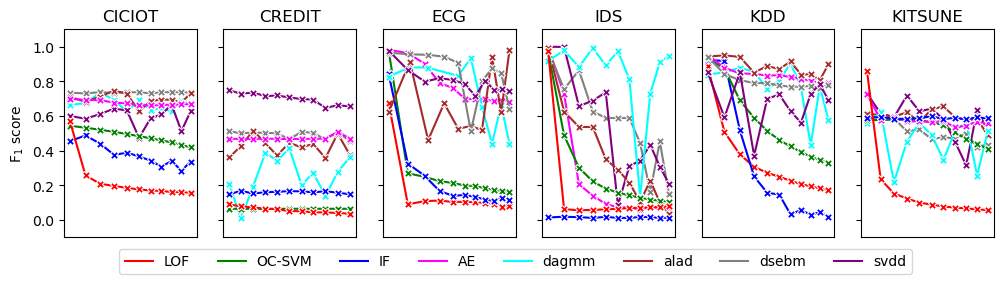

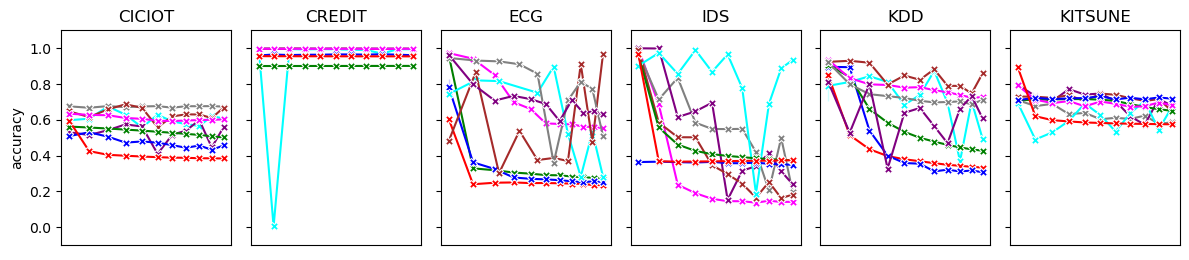

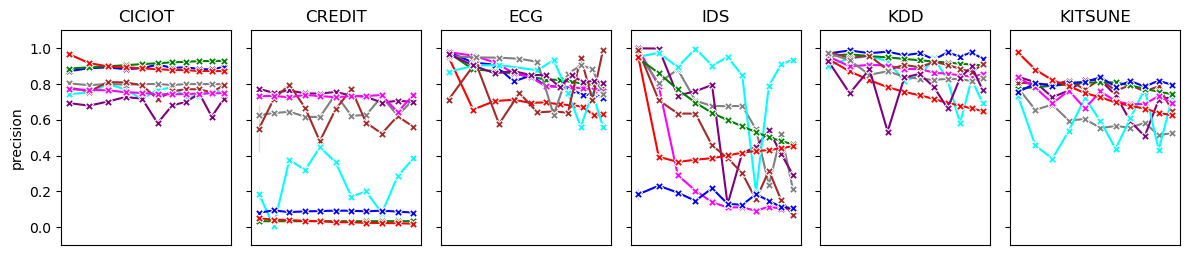

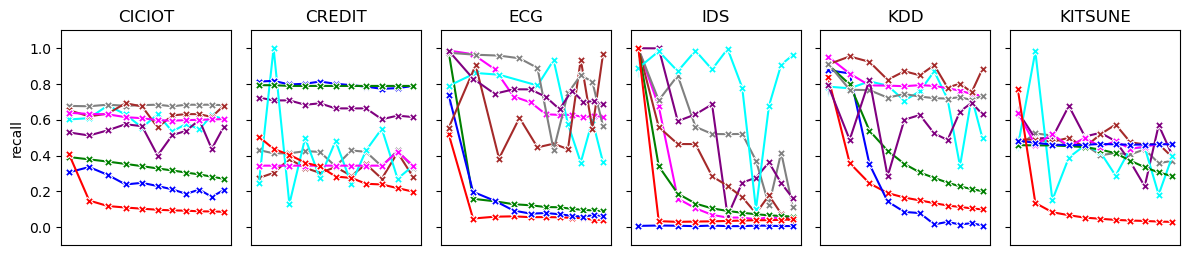

In [36]:
metrics = ["f1", "accuracy", "precision", "recall"]
color_palette_ = {
    "IF": "blue",
    "LOF": "red",
    "OC-SVM": "green",
    "AE": "magenta",
    "dsebm": "gray",
    "alad": "brown",
    "svdd": "purple",
    "dagmm": "cyan" 
}
for metric in metrics:
    degration = df_perf[~df_perf['model'].str.contains('Bopeto')]
    fig, axes = plt.subplots(ncols=6, figsize=(12, 2.7), sharey=True)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, degration.groupby('dataset'))):
        sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=color_palette_)
        ax.set_title(f'{subplot}'.upper())
        ax.set_xlabel('')
        ax.set_xticks([])
        if metric=="f1":
            ax.set_ylabel(r'F$_1$ score')
        else:
            ax.set_ylabel(metric)
        ax.set_ylim(-0.1, 1.1)
        if i != 2 or metric!="f1":
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
                    label.set_font('bold')
            ax.legend(loc='lower center', bbox_to_anchor=(1., -0.21), ncol=8)
            #ax.legend().get_frame().set_linewidth(1)
    plt.tight_layout()
    plt.savefig("degration_"+metric+".pdf")
    plt.show()

In [21]:
degration_perf = df_perf[~df_perf['model'].str.contains('Bopeto')]
degration_perf.groupby('dataset')['accuracy'].agg(['mean', 'std'])

,mean,std
dataset,,
ciciot,0.561744,0.087940
credit,0.964368,0.104106
ecg,0.553194,0.259302
ids,0.511593,0.284357
kdd,0.663395,0.200887
kitsune,0.681469,0.071228


In [22]:
df_perf[df_perf['contamination']==0].head(10)

,dataset,contamination,model,accuracy,precision,recall,f1,Unnamed: 0
485,ciciot,0.0,Bopeto_dsebm,0.675352,0.799129,0.683713,0.736929,NaN
484,ciciot,0.0,dsebm,0.674862,0.807073,0.671678,0.733177,NaN
483,ciciot,0.0,dsebm,0.675878,0.799773,0.683849,0.737282,NaN
462,ciciot,0.0,Bopeto_svdd,0.643638,0.788447,0.634383,0.703074,NaN
506,ciciot,0.0,alad,0.684577,0.805721,0.692766,0.744987,NaN
530,ciciot,0.0,dagmm,0.599973,0.746658,0.603169,0.667287,NaN
531,ciciot,0.0,Bopeto_dagmm,0.616495,0.758065,0.621803,0.683206,NaN
529,ciciot,0.0,dagmm,0.595663,0.741947,0.601096,0.664136,NaN
461,ciciot,0.0,svdd,0.529081,0.691702,0.526651,0.597997,NaN
507,ciciot,0.0,alad,0.610831,0.755218,0.613776,0.677190,NaN


In [23]:
def sort_group(group):
    return group.sort_values(by='dataset')

In [24]:
df_perf.head()

,dataset,contamination,model,accuracy,precision,recall,f1,Unnamed: 0
546,ciciot,0.214762,dagmm,0.565927,0.732020,0.547894,0.626713,NaN
485,ciciot,0.000000,Bopeto_dsebm,0.675352,0.799129,0.683713,0.736929,NaN
486,ciciot,0.033057,dsebm,0.667596,0.793721,0.675832,0.730048,NaN
487,ciciot,0.033057,Bopeto_dsebm,0.676101,0.799960,0.684031,0.737467,NaN
488,ciciot,0.063999,dsebm,0.676694,0.800257,0.684795,0.738037,NaN


In [25]:
models = ["AE", "OC-SVM", "LOF", "IF", "svdd", "alad", "dsebm", "dagmm"]
names = ["CICIOT", "CREDIT", "ECG", "IDS", "KDD", "KITSUNE"]

In [26]:
def get_diff(model, dataset):
    n_db = pd.DataFrame([])
    ds = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]==model)]
    ds_b = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]=="Bopeto_"+model)]
    contamination = np.unique(ds["contamination"].values)
    diff_acc = []
    diff_f1 = []
    diff_prec = []
    diff_rec = []
    for c in contamination:
        acc = ds_b.loc[ds_b['contamination']==c, "accuracy"].values[0]
        acc -= ds.loc[ds['contamination']==c, "accuracy"].values[0]
        diff_acc.append(acc)
        f1 = ds_b.loc[ds_b['contamination']==c, "f1"].values[0]
        f1 -= ds.loc[ds['contamination']==c, "f1"].values[0]
        diff_f1.append(f1)
        prec = ds_b.loc[ds_b['contamination']==c, "precision"].values[0]
        prec -= ds.loc[ds['contamination']==c, "precision"].values[0]
        diff_prec.append(prec)
        rec = ds_b.loc[ds_b['contamination']==c, "recall"].values[0]
        rec -= ds.loc[ds['contamination']==c, "recall"].values[0]
        diff_rec.append(rec)
    n_db["accuracy"] = diff_acc
    n_db["precision"] = diff_prec
    n_db["f1"] = diff_f1
    n_db["recall"] = diff_rec
    n_db["contamination"] = contamination
    n_db["dataset"]=dataset
    n_db["model"] = model
    n_db["id"]=range(len(contamination))
    return n_db
    

In [27]:
get_diff("svdd", "ecg")

,accuracy,precision,f1,recall,contamination,dataset,model,id
0,-0.009052,-0.001522,-0.005866,-0.010267,0.000000,ecg,svdd,0
1,-0.058040,-0.033715,-0.040447,-0.045859,0.065217,ecg,svdd,1
2,0.160277,0.072715,0.114667,0.149213,0.123066,ecg,svdd,2
3,-0.105964,-0.062939,-0.077876,-0.088296,0.173625,ecg,svdd,3
4,-0.031416,-0.012334,-0.024219,-0.033539,0.219161,ecg,svdd,4
5,0.020234,0.004973,0.016647,0.025325,0.259501,ecg,svdd,5
6,0.075080,0.042766,0.057072,0.067077,0.296275,ecg,svdd,6
7,-0.107029,-0.057612,-0.080883,-0.097878,0.329209,ecg,svdd,7
8,-0.024494,-0.013025,-0.019040,-0.023272,0.359527,ecg,svdd,8
9,-0.029819,-0.018465,-0.022168,-0.024641,0.386922,ecg,svdd,9


In [28]:
difference = pd.DataFrame([])
for d_name in names:
    for m_name in models:
        difference = pd.concat([difference, get_diff(m_name, d_name.lower())], ignore_index=True)

/tmp/ipykernel_10041/1991306361.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


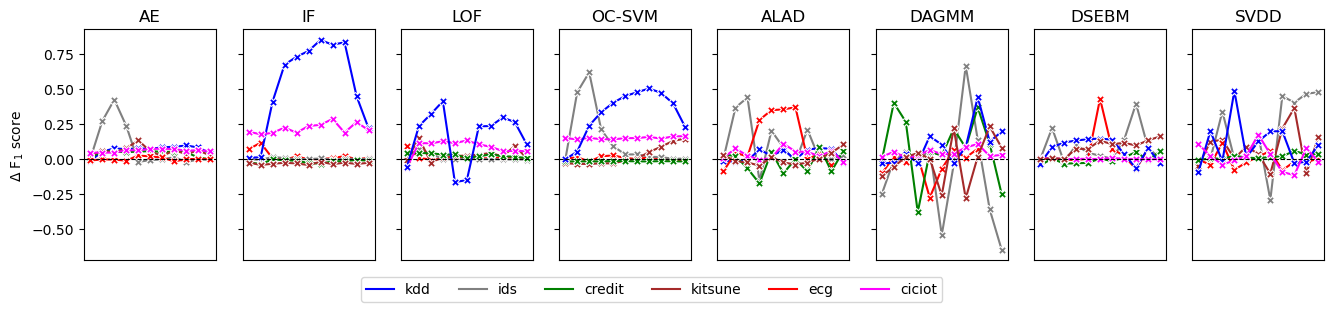

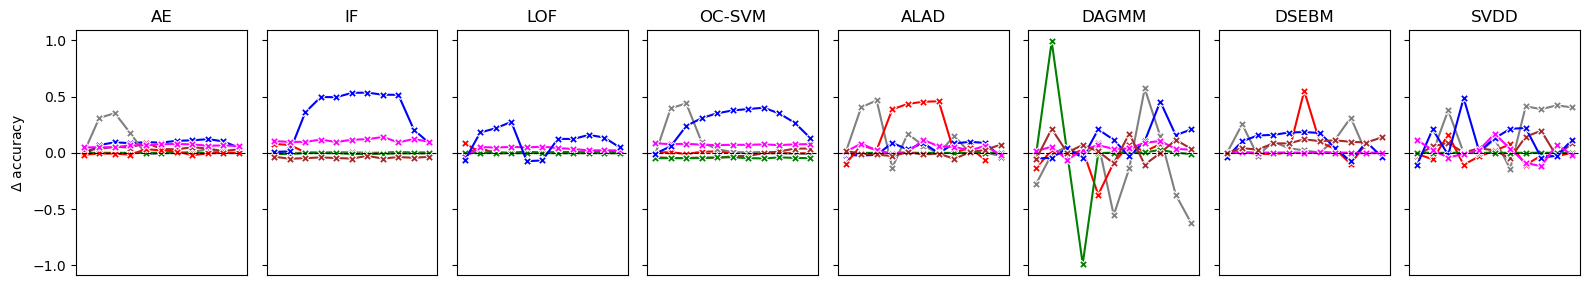

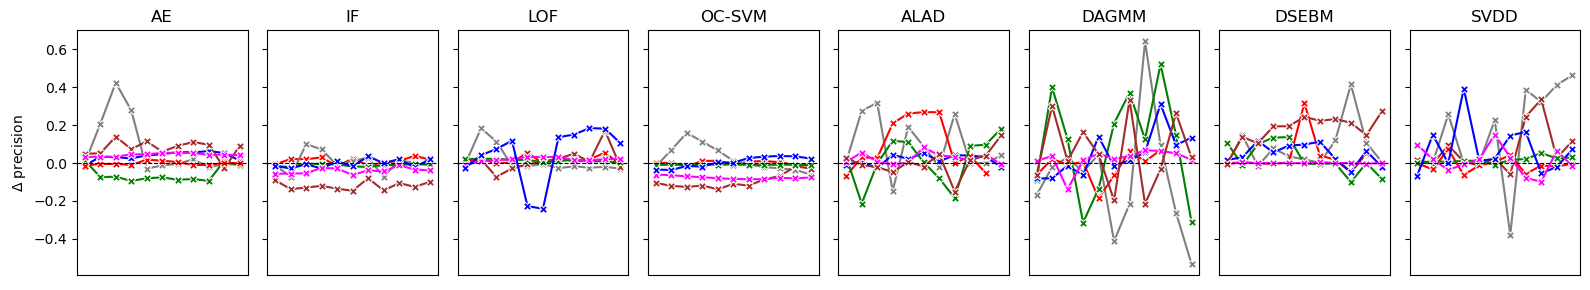

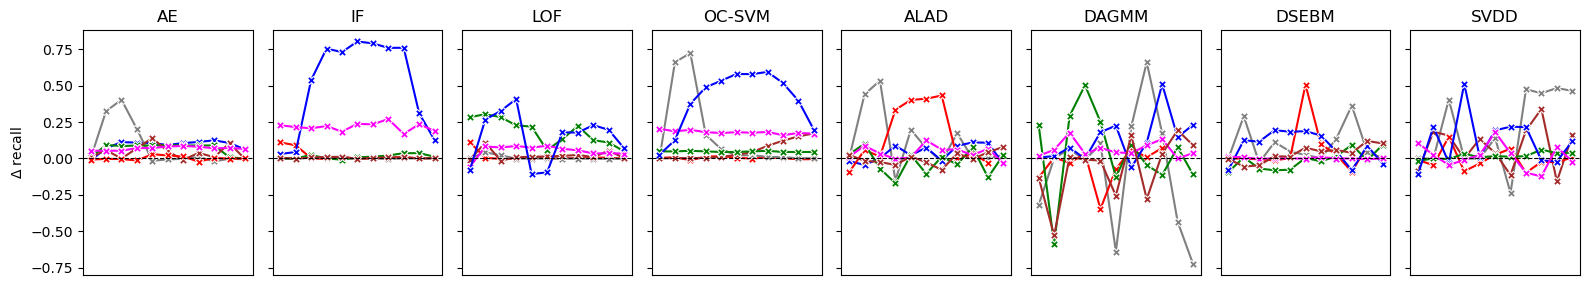

In [41]:
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'x', '+', '*']
color_palette = {
    "kdd": "blue",
    "ecg": "red",
    "credit": "green",
    "ciciot": "magenta",
    "ids": "gray",
    "kitsune": "brown"  
}
for metric in metrics:
    robustness = difference.sort_values(by='contamination')
    fig, axes = plt.subplots(ncols=8, figsize=(16, 3), sharey=True)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('model'))):
        sns.lineplot(data=df_group, x=df_group.id, y=metric, hue='dataset', ax=ax, marker='X', palette=color_palette)
        ax.set_title(f'{subplot}'.upper())
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xticks([])
        if metric=="f1":
            ax.set_ylabel(r'$\Delta$ F$_1$ score')
        else:    
            ax.set_ylabel(r'$\Delta$ {}'.format(metric))

        if i != 0 or metric!="f1":
            ax.legend().set_visible(False)
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
                    label.set_font('bold')
                ax.legend(loc='lower center', bbox_to_anchor=(4.3, -0.21), ncol=6)
    plt.tight_layout()
    plt.savefig(metric+"_difference.pdf")
    plt.show()

In [34]:
def swap_prefix(name):
    if '_' in name:
        parts = name.split('_')
        return f"{parts[1]}_{parts[0]}"
    else:
        return name

In [35]:
def get_detail_summary(df_perf, metric):
    grouped_perf = df_perf.groupby(['model', 'dataset']).agg({metric: ['mean', 'std']})
    grouped_perf.columns = ['_'.join(col).strip() for col in grouped_perf.columns.values]
    grouped_perf[metric+'_mean'] = grouped_perf[metric+'_mean'].round(3)
    grouped_perf[metric+'_std'] = grouped_perf[metric+'_std'].round(3)
    grouped_perf[metric] = grouped_perf[metric+'_mean'].astype(str) + ' ± ' + grouped_perf[metric+'_std'].astype(str)
    pivot_df = grouped_perf.reset_index().pivot(index='model', columns='dataset', values=metric)
    pivot_df.rename(index=lambda x: swap_prefix(x), inplace=True)
    pivot_df.sort_index(inplace=True)
    return pivot_df

In [36]:
def remove_sign(value):
    if isinstance(value, str):
        parts = value.split(' ± ')
        if len(parts) > 1:
            return float(parts[0])  # Convert the value to float
    return value

In [37]:
def get_general_summary(df):
    data = df.applymap(remove_sign)
    df_basic = data[~data.index.str.contains('Bopeto')] 
    df_basic.sort_index(inplace=True)
    df_bopeto = data[data.index.str.contains('Bopeto')] 
    df_bopeto.sort_index(inplace=True)
    diff = df_bopeto.values - df_basic.values
    return pd.DataFrame(data=diff, index=df_basic.index, columns=df_basic.columns)

In [38]:
def get_latex(df, metric):
    return df.to_latex(index=False, 
                          caption='Example Table', 
                          label='tab:summary_'+metric, 
                          column_format='|c|c|c|c|c|c|c|')

In [39]:
f1_df = get_detail_summary(df_perf, "f1")
f1_df

dataset,ciciot,credit,ecg,ids,kdd,kitsune
model,,,,,,
AE,0.677 ± 0.015,0.472 ± 0.012,0.794 ± 0.126,0.298 ± 0.376,0.847 ± 0.056,0.592 ± 0.064
AE_Bopeto,0.734 ± 0.006,0.511 ± 0.02,0.778 ± 0.114,0.314 ± 0.384,0.903 ± 0.03,0.634 ± 0.052
IF,0.382 ± 0.064,0.158 ± 0.008,0.276 ± 0.272,0.015 ± 0.003,0.335 ± 0.379,0.588 ± 0.007
IF_Bopeto,0.592 ± 0.043,0.142 ± 0.008,0.242 ± 0.23,0.015 ± 0.006,0.806 ± 0.226,0.555 ± 0.004
LOF,0.249 ± 0.154,0.06 ± 0.019,0.193 ± 0.225,0.218 ± 0.353,0.373 ± 0.258,0.23 ± 0.299
LOF_Bopeto,0.3 ± 0.086,0.083 ± 0.029,0.162 ± 0.2,0.158 ± 0.271,0.482 ± 0.25,0.205 ± 0.231
OC-SVM,0.488 ± 0.043,0.065 ± 0.0,0.333 ± 0.303,0.325 ± 0.32,0.571 ± 0.231,0.533 ± 0.062
OC-SVM_Bopeto,0.633 ± 0.036,0.048 ± 0.001,0.278 ± 0.236,0.401 ± 0.364,0.86 ± 0.115,0.551 ± 0.007
alad,0.7 ± 0.035,0.418 ± 0.055,0.68 ± 0.193,0.418 ± 0.327,0.891 ± 0.049,0.595 ± 0.043


In [40]:
#print(get_latex(f1_df, "f1"))

In [41]:
gen = get_general_summary(f1_df)
gen.stack().mean(), gen.stack().std()

(0.04477083333333334, 0.09395477399652233)

In [42]:
prec_df = get_detail_summary(df_perf, "precision")
prec_df

dataset,ciciot,credit,ecg,ids,kdd,kitsune
model,,,,,,
AE,0.754 ± 0.011,0.726 ± 0.027,0.85 ± 0.087,0.338 ± 0.363,0.888 ± 0.038,0.737 ± 0.059
AE_Bopeto,0.797 ± 0.004,0.665 ± 0.034,0.836 ± 0.077,0.355 ± 0.376,0.918 ± 0.021,0.804 ± 0.045
IF,0.887 ± 0.011,0.088 ± 0.005,0.833 ± 0.092,0.164 ± 0.044,0.967 ± 0.016,0.797 ± 0.025
IF_Bopeto,0.849 ± 0.013,0.078 ± 0.005,0.832 ± 0.082,0.163 ± 0.057,0.963 ± 0.009,0.681 ± 0.014
LOF,0.899 ± 0.034,0.033 ± 0.01,0.722 ± 0.11,0.499 ± 0.212,0.771 ± 0.102,0.768 ± 0.123
LOF_Bopeto,0.911 ± 0.02,0.046 ± 0.016,0.718 ± 0.086,0.471 ± 0.169,0.801 ± 0.15,0.762 ± 0.101
OC-SVM,0.911 ± 0.016,0.034 ± 0.0,0.853 ± 0.065,0.666 ± 0.176,0.936 ± 0.021,0.784 ± 0.021
OC-SVM_Bopeto,0.837 ± 0.01,0.025 ± 0.001,0.842 ± 0.056,0.663 ± 0.205,0.939 ± 0.011,0.691 ± 0.025
alad,0.775 ± 0.029,0.623 ± 0.114,0.754 ± 0.147,0.483 ± 0.311,0.92 ± 0.038,0.782 ± 0.048


In [43]:
gen = get_general_summary(prec_df)
gen.stack().mean(), gen.stack().std()

(0.012958333333333336, 0.05210870729433351)

In [44]:
rec_df = get_detail_summary(df_perf, "recall")
rec_df

dataset,ciciot,credit,ecg,ids,kdd,kitsune
model,,,,,,
AE,0.614 ± 0.017,0.351 ± 0.022,0.749 ± 0.159,0.277 ± 0.381,0.811 ± 0.073,0.497 ± 0.071
AE_Bopeto,0.681 ± 0.007,0.417 ± 0.035,0.73 ± 0.144,0.292 ± 0.386,0.888 ± 0.039,0.526 ± 0.068
IF,0.245 ± 0.053,0.798 ± 0.015,0.2 ± 0.257,0.008 ± 0.001,0.281 ± 0.368,0.467 ± 0.011
IF_Bopeto,0.457 ± 0.055,0.81 ± 0.007,0.166 ± 0.218,0.008 ± 0.003,0.739 ± 0.258,0.468 ± 0.003
LOF,0.154 ± 0.119,0.334 ± 0.109,0.131 ± 0.183,0.197 ± 0.375,0.28 ± 0.271,0.175 ± 0.279
LOF_Bopeto,0.183 ± 0.065,0.502 ± 0.183,0.108 ± 0.174,0.129 ± 0.289,0.372 ± 0.237,0.142 ± 0.213
OC-SVM,0.335 ± 0.042,0.79 ± 0.002,0.26 ± 0.337,0.267 ± 0.351,0.451 ± 0.273,0.406 ± 0.065
OC-SVM_Bopeto,0.511 ± 0.05,0.838 ± 0.004,0.198 ± 0.262,0.352 ± 0.403,0.81 ± 0.167,0.458 ± 0.001
alad,0.639 ± 0.039,0.318 ± 0.047,0.626 ± 0.225,0.377 ± 0.336,0.864 ± 0.063,0.482 ± 0.044


In [45]:
gen = get_general_summary(rec_df)
gen.stack().mean(), gen.stack().std()

(0.05314583333333334, 0.10061999073474909)

In [46]:
acc_df = get_detail_summary(df_perf, "accuracy")
acc_df

dataset,ciciot,credit,ecg,ids,kdd,kitsune
model,,,,,,
AE,0.61 ± 0.016,0.997 ± 0.0,0.709 ± 0.175,0.344 ± 0.341,0.797 ± 0.072,0.707 ± 0.041
AE_Bopeto,0.672 ± 0.007,0.997 ± 0.0,0.684 ± 0.157,0.362 ± 0.344,0.867 ± 0.039,0.741 ± 0.03
IF,0.477 ± 0.03,0.963 ± 0.003,0.363 ± 0.201,0.36 ± 0.006,0.492 ± 0.251,0.719 ± 0.007
IF_Bopeto,0.584 ± 0.025,0.957 ± 0.003,0.336 ± 0.169,0.359 ± 0.007,0.798 ± 0.173,0.677 ± 0.006
LOF,0.428 ± 0.079,0.955 ± 0.0,0.304 ± 0.142,0.47 ± 0.232,0.46 ± 0.189,0.637 ± 0.12
LOF_Bopeto,0.445 ± 0.043,0.953 ± 0.001,0.287 ± 0.135,0.426 ± 0.179,0.52 ± 0.162,0.621 ± 0.091
OC-SVM,0.536 ± 0.021,0.901 ± 0.0,0.406 ± 0.262,0.507 ± 0.219,0.598 ± 0.186,0.697 ± 0.024
OC-SVM_Bopeto,0.608 ± 0.023,0.856 ± 0.004,0.357 ± 0.203,0.55 ± 0.251,0.831 ± 0.108,0.678 ± 0.01
alad,0.637 ± 0.038,0.996 ± 0.0,0.567 ± 0.25,0.435 ± 0.295,0.853 ± 0.064,0.719 ± 0.027


In [47]:
gen = get_general_summary(acc_df)
gen.stack().mean(), gen.stack().std()

(0.0319375, 0.0730276561573065)

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


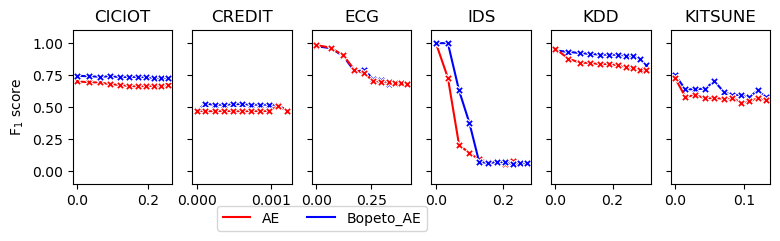

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


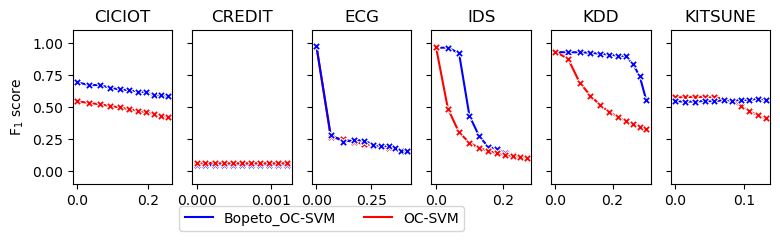

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


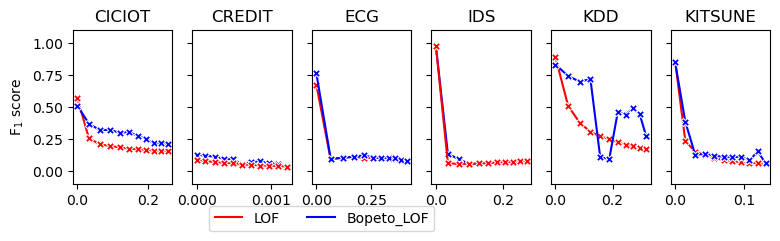

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


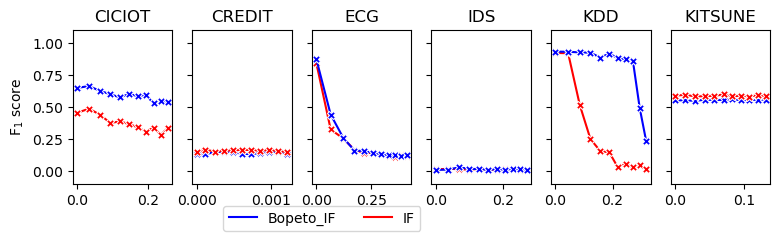

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


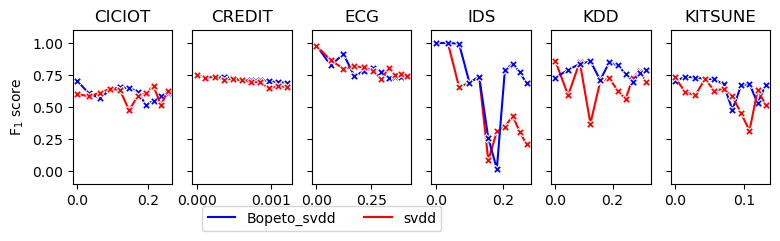

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


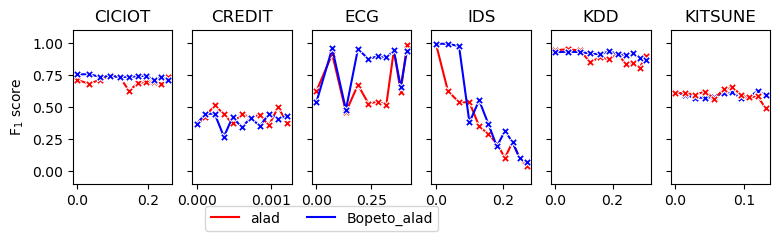

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


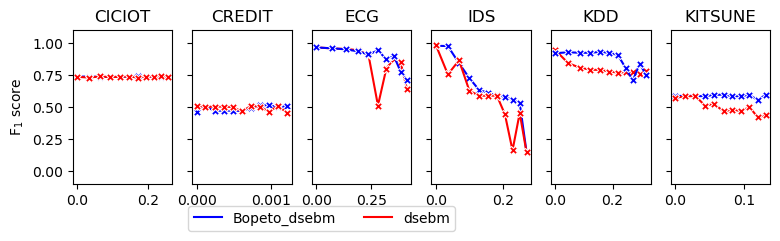

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


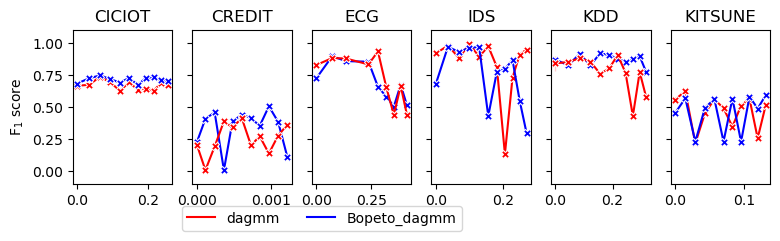

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


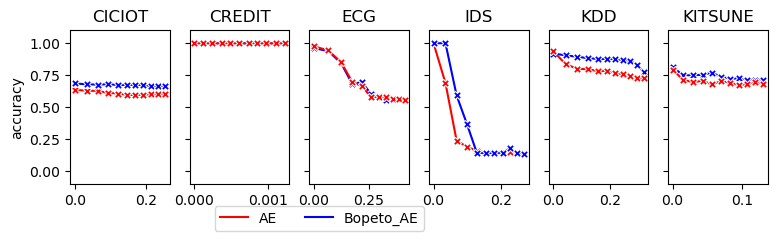

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


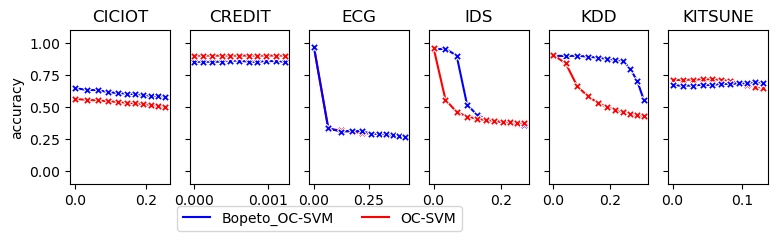

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


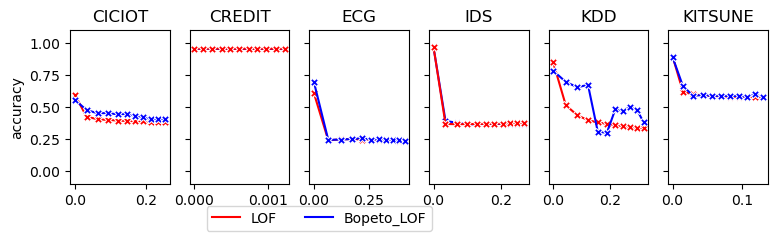

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


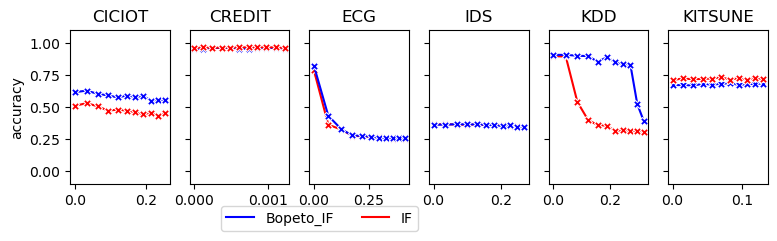

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


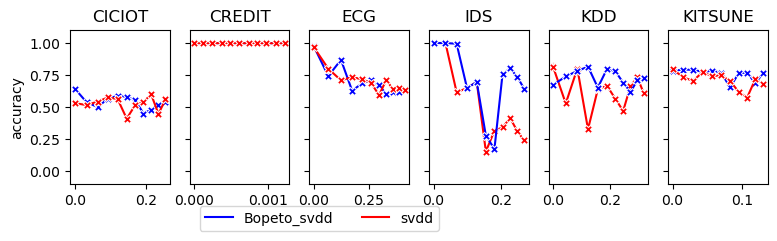

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


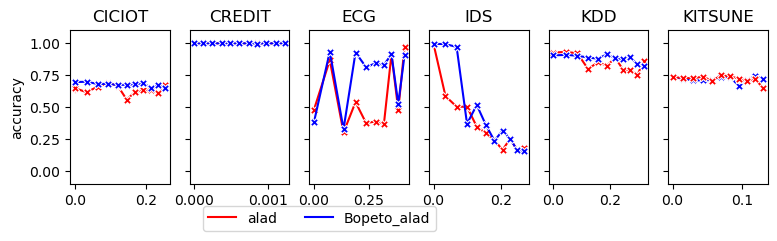

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


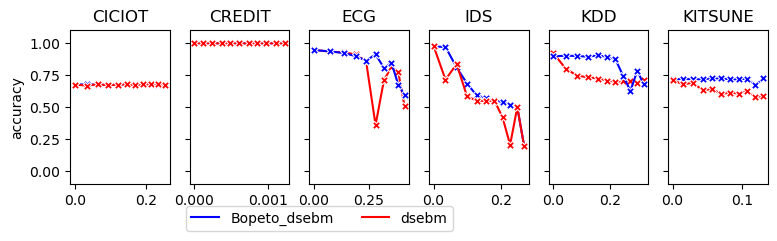

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


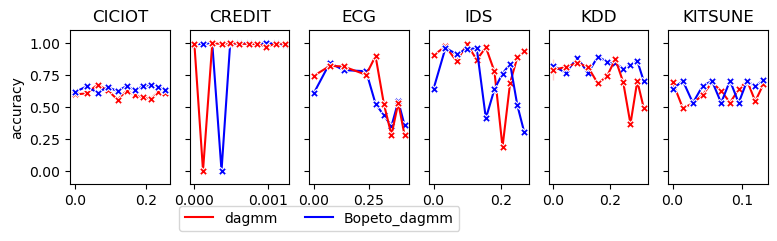

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


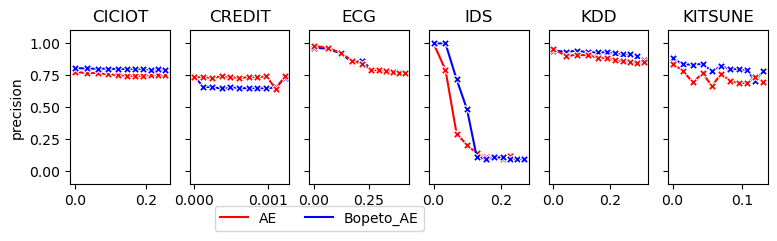

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


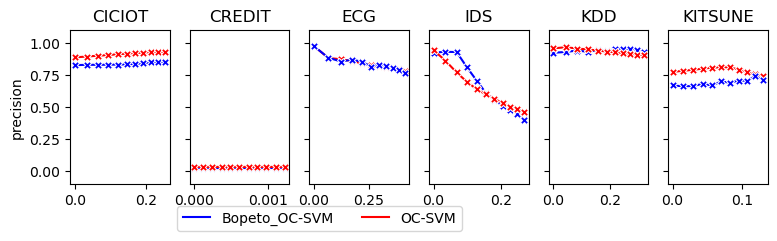

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


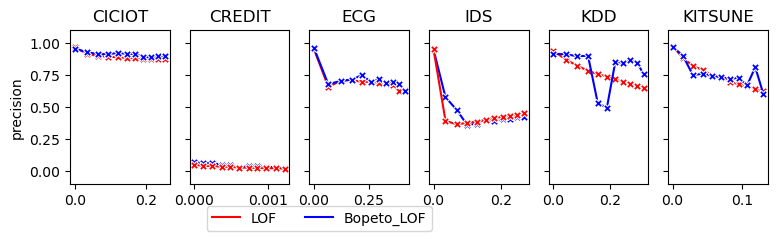

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


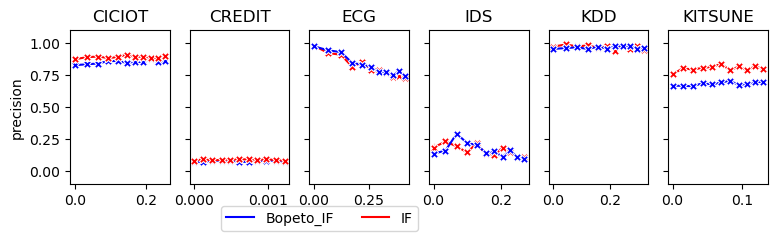

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


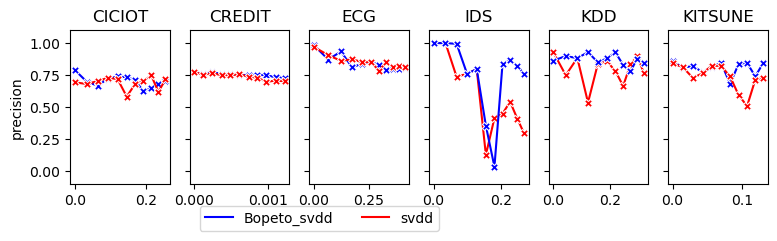

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


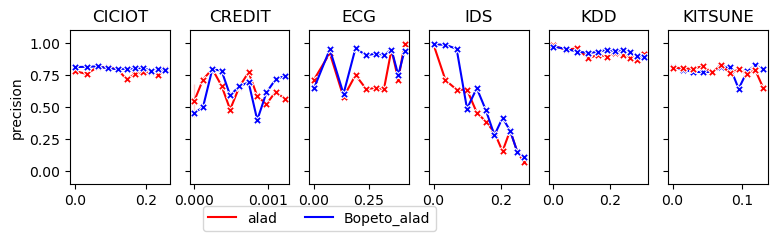

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


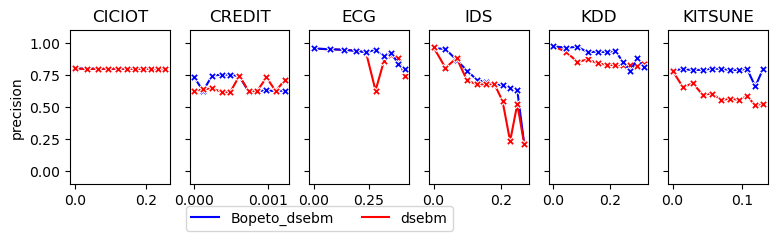

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


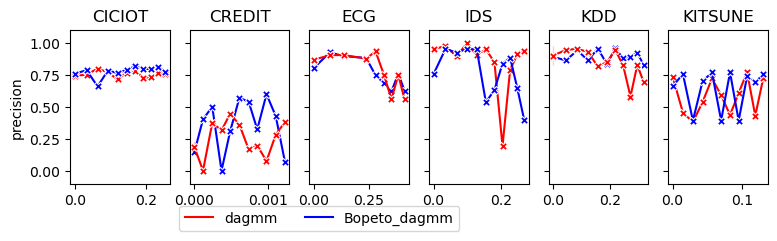

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


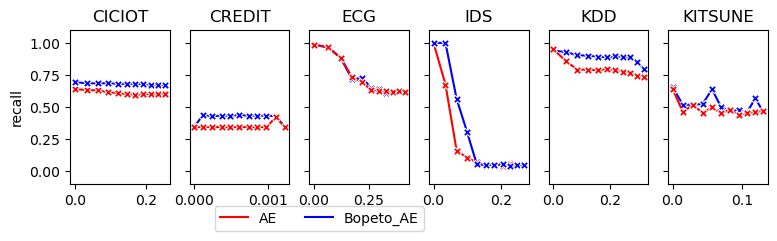

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


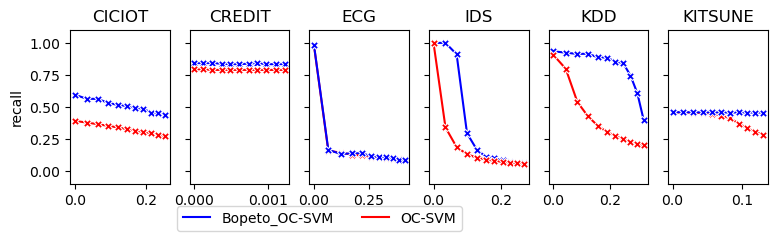

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


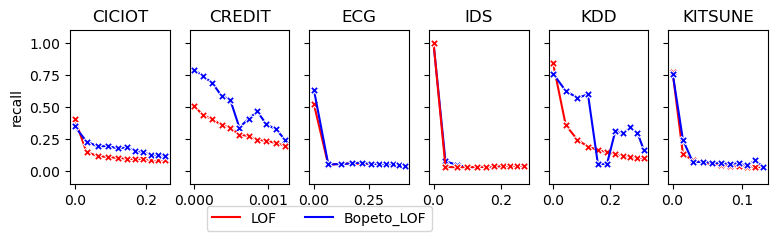

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


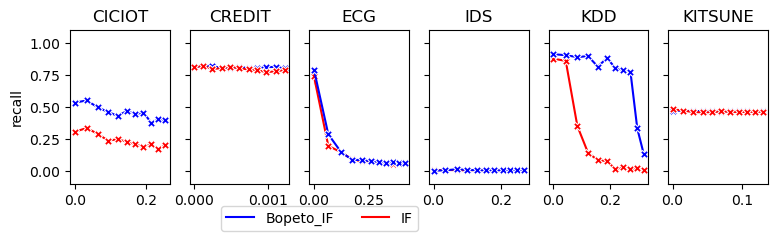

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


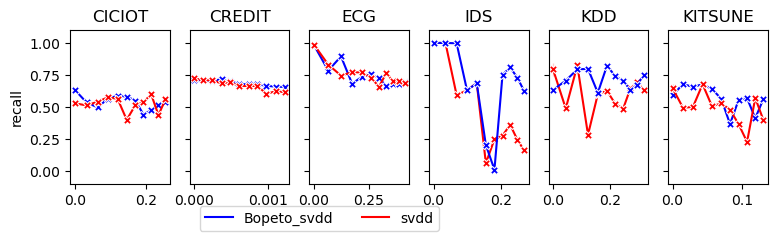

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


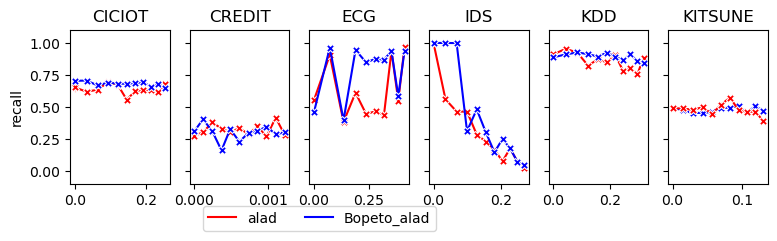

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


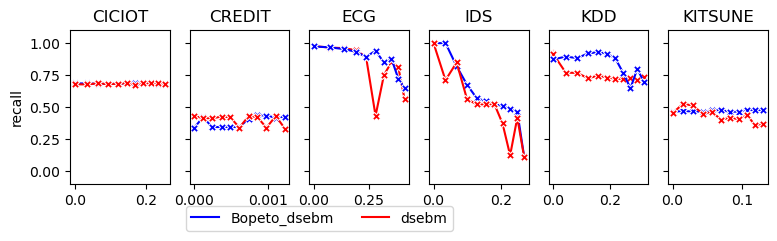

/tmp/ipykernel_227970/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


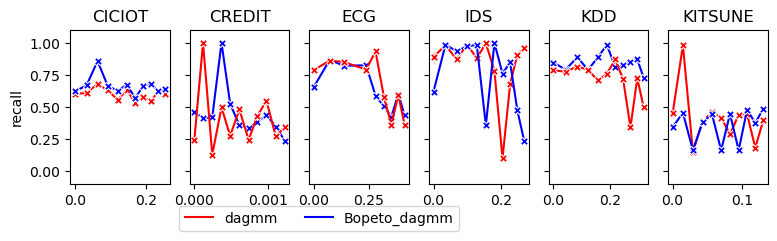

In [48]:
for metric in metrics:
    for model in models:
        palette ={'Bopeto_'+model: 'blue', model: 'red'}
        robustness = df_perf[df_perf['model'].str.contains(model)]
        robustness = robustness.sort_values(by='dataset')
        fig, axes = plt.subplots(ncols=6, figsize=(9, 2), sharey=True)
        for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('dataset'))):
            sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette)
            ax.set_title(f'{subplot}'.upper())
            ax.set_xlabel('')
            if metric=="f1":
                ax.set_ylabel(r'F$_1$ score')
            else:
                ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.1)

            if i != 0:
                ax.legend().remove()
            else:
                ax.legend(loc='lower center', bbox_to_anchor=(2.5, -0.35), ncol=2)
        plt.tight_layout()
        plt.savefig(model+"_"+metric+"_robustness.pdf")
        plt.show()

In [49]:
df_group

,dataset,contamination,model,accuracy,precision,recall,f1,Unnamed: 0
360,kitsune,0.095550,dagmm,0.637655,0.608923,0.440268,0.511040,NaN
361,kitsune,0.095550,Bopeto_dagmm,0.532159,0.393614,0.162392,0.229924,NaN
362,kitsune,0.107730,dagmm,0.705309,0.772621,0.446095,0.565616,NaN
345,kitsune,0.000000,dagmm,0.689971,0.744325,0.425206,0.541228,NaN
364,kitsune,0.119587,dagmm,0.545150,0.431820,0.182337,0.256406,NaN
365,kitsune,0.119587,Bopeto_dagmm,0.660530,0.694617,0.376000,0.487898,NaN
346,kitsune,0.000000,dagmm,0.697702,0.726137,0.477039,0.575802,NaN
359,kitsune,0.083032,Bopeto_dagmm,0.705097,0.770847,0.447285,0.566094,NaN
363,kitsune,0.107730,Bopeto_dagmm,0.703615,0.740247,0.478926,0.581581,NaN
358,kitsune,0.083032,dagmm,0.534718,0.437820,0.288095,0.347516,NaN


In [62]:
dd_ecg = np.load("../data/ecg.npz", allow_pickle=True) 
dd_credit = np.load("../data/credit.npz", allow_pickle=True) 
data1_ecg = pd.DataFrame(dd_ecg['ecg'])
data1_credit = pd.DataFrame(dd_credit['credit'])

In [63]:
np.unique(data1_credit.values[:, -1])

array([0., 1.])

In [66]:
data1_kdd = pd.read_csv("../outputs_backup/kdd.csv")
data1_ids = pd.read_csv("../outputs_backup/ids.csv")
data1_ciciot = pd.read_csv("../outputs_backup/ciciot.csv")
data_kitsune = pd.read_csv("../outputs_backup/kitsune.csv")

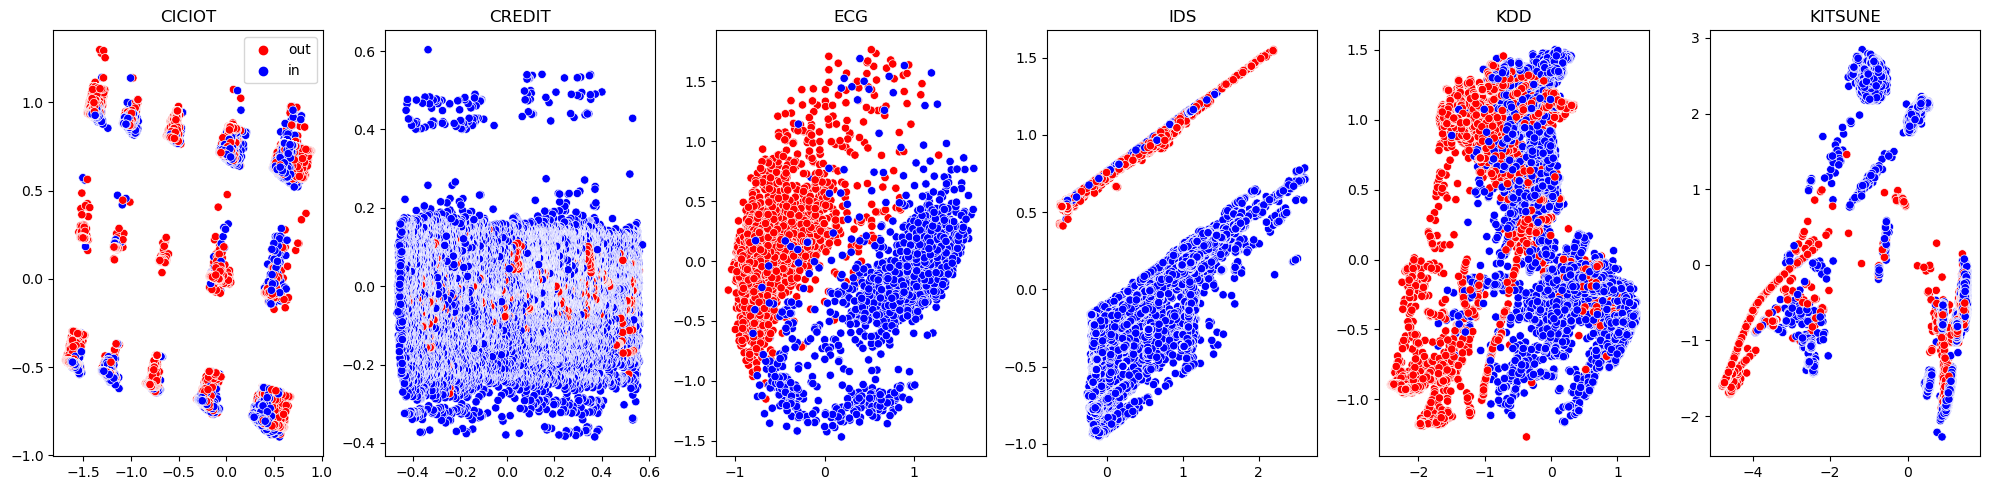

In [67]:

datasets = [data1_ciciot, data1_credit, data1_ecg, data1_ids, data1_kdd, data_kitsune]
pca = PCA(n_components=2)
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
replacement_dict = {
    0: 'in',
    1: 'out',
    2: 'synthetic'
}
for i, xy in enumerate(datasets):
    
    x, y = xy.values[:, :-1], xy.values[:, -1]
    reduced_data = pca.fit_transform(x)
    df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
    df_pca['target'] = y
    df_pca['target'] = df_pca['target'].replace(replacement_dict)
    df_pca = df_pca[df_pca['target']!='synthetic']

    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', ax=axs[i], palette={'in':'blue', 'out':'red', 'synthetic':'green'}, legend=(i==0))
    axs[i].set_title(names[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    if i == 0:
        axs[i].legend(title='')
    else:
        axs[i].legend([],[], frameon=False)

plt.tight_layout()
plt.savefig("synthetic.png")
plt.show()


In [43]:
def sdc(dynamics):
    return np.std(np.diff(dynamics, axis=1), axis=1)

In [62]:
def extract_data(path):
    raw = np.load(path, allow_pickle=True)
    keys = list(raw.keys())
    train = raw[keys[-2]]
    weights = raw[keys[-1]]
    hard = weights[:, 0]
    soft = weights[:, 1]
    y = train[:, -1]
    threshold = np.min(soft[hard==1])
    return soft, y, threshold
    

In [95]:
soft_kdd, y_kdd, threshold_kdd = extract_data("../detection/kdd_plot.npz")
soft_kitsune, y_kitsune, threshold_kitsune = extract_data("../detection/kitsune_plot.npz")
soft_ids, y_ids, threshold_ids = extract_data("../detection/ids_plot.npz")
soft_ecg, y_ecg, threshold_ecg = extract_data("../detection/ecg_plot.npz")
soft_credit, y_credit, threshold_credit = extract_data("../detection/credit_plot.npz")
soft_ciciot, y_ciciot, threshold_ciciot = extract_data("../detection/ciciot_plot.npz")

In [112]:
softs = [soft_ciciot, soft_credit, soft_ecg, soft_ids, soft_kdd, soft_kitsune]
ys = [y_ciciot, y_credit, y_ecg, y_ids, y_kdd, y_kitsune]
thresholds =[threshold_ciciot, threshold_credit-0.35, threshold_ecg, threshold_ids, threshold_kdd, threshold_kitsune-0.3]

In [113]:
ys[1].shape, softs[1].shape

((125501,), (125501,))

In [85]:
thresholds[2]

0.6391736343829172

In [40]:
kdd_1 = np.loadtxt("kdd_FGM_sdc_ae_rate_0.18821442994855225.csv", delimiter=',')
ids_1 = np.loadtxt("ids_FGM_sdc_ae_rate_0.15585998801128825.csv", delimiter=',')
credit_1 = np.loadtxt("credit_FGM_sdc_ae_rate_0.0012223312434517968.csv", delimiter=',')
ecg_1 = np.loadtxt("ecg_FGM_sdc_ae_rate_0.21916092673763307.csv", delimiter=',')
ciciot_1 = np.loadtxt("ciciot_FGM_sdc_ae_rate_0.19310100024086915.csv", delimiter=',')
kitsune_1 = np.loadtxt("kitsune_FGM_sdc_ae_rate_0.0701628076642476.csv", delimiter=',')

In [41]:
x_kdd, y_kdd = kdd_1[:, :-1], kdd_1[:, -1]
x_ids, y_ids = ids_1[:, :-1], ids_1[:, -1]
x_ciciot, y_ciciot = ciciot_1[:, :-1], ciciot_1[:, -1]
x_kitsune, y_kitsune = kitsune_1[:, :-1], kitsune_1[:, -1]
x_credit, y_credit = credit_1[:, :-1], credit_1[:, -1]
x_ecg, y_ecg = ecg_1[:, :-1], ecg_1[:, -1]

In [44]:
m = 'score'
mac_kdd = sdc(x_kdd)
mac_ids = sdc(x_ids)
mac_ciciot = sdc(x_ciciot)
mac_kitsune = sdc(x_kitsune)
mac_credit = sdc(x_credit)
mac_ecg = sdc(x_ecg)

In [45]:
mapping = {0: 'in', 1: 'out', 2:'synthetic'}
def clean(dynamics, target, n=1000):
    detector = IsolationForest(n_estimators=50, random_state=42)
    df = pd.DataFrame(data = dynamics, columns=[m])
    df['class'] = target
    df['class'] = df['class'].replace(mapping)
    y_pred = detector.fit_predict(dynamics.reshape(-1, 1))
    anomaly_scores = detector.decision_function(dynamics.reshape(-1, 1))
    out = anomaly_scores[y_pred==-1]
    in_ = anomaly_scores[y_pred==1]
    threshold = (np.max(out)+np.min(in_))/2
    threshold = np.percentile(out, np.random.randint(60, 70, 1)[0])
    y_pred = anomaly_scores >= threshold

    df[m] = anomaly_scores
    y = y_pred==1
    sample = df.sample(n=n)
    selected = df.index.isin(sample.index)
    cleaned = df[y & selected].copy()
    return sample, cleaned, threshold 

In [46]:
all_data = [clean(mac_ciciot, y_ciciot), clean(mac_credit, y_credit), 
            clean(mac_ecg, y_ecg), clean(mac_ids, y_ids), 
            clean(mac_kdd, y_kdd), clean(mac_kitsune, y_kitsune)]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


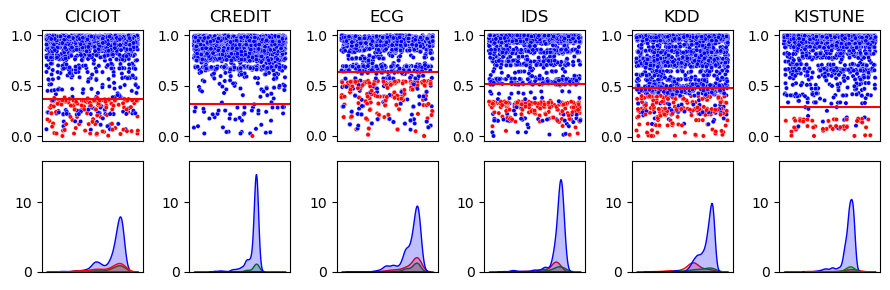

In [120]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
datasets = ["CICIOT", "CREDIT", "ECG", "IDS", "KDD", "KISTUNE"]
palette = {"out":"red", "synthetic":"green", "in":"blue"}
for i, df in enumerate(all_data):
    df_soft = pd.DataFrame(data = softs[i], columns=["weight"])
    df_soft['class'] = ys[i].astype(int)
    df_soft['class'] = df_soft['class'].replace(mapping)
    #anomalies = df_soft[df_soft['class']=='out'].sample(n=1000,replace=True)
    df_soft = df_soft.sample(n=2000,replace=True)
    #df_soft = pd.concat([df_soft,anomalies], axis=0, ignore_index=True)
    #df_soft = df_soft.sample(frac = 1)
    for j in range(1):
        d = df[j]
        d = d.sort_index()
        ax = axes[0, i]
        
        sns.scatterplot(data=df_soft, x=df_soft.index, y="weight", hue='class', ax=ax, palette=palette, s=10)
        ax.axhline(y=thresholds[i], color='r', linestyle='-')
        ax.set_ylabel(None)
        if j==0:
            ax.set_title(datasets[i])
        if i!=0 or j!=1:
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
        
        
        ax.set_xticks([])
        ax = axes[1, i]
        sns.kdeplot(data= d, x='score', hue='class', fill=True, ax=ax, palette=palette)
        ax.legend().remove()
        ax.set_xticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        if i!=0:
            axes[0, i].set_ylabel('')
            axes[1, i].set_ylabel('')
        else:
            pass
            #axes[1, 0].set_ylabel('density')
        ax.set_ylim(0, 16)
plt.tight_layout()
plt.savefig("dynamics_space.png")
plt.show()

In [ ]:
d

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
thresholds = [0.008, 0.015, 0.02]
for i, df in enumerate([df_kdd.sample(n=1000), df_ciciot.sample(n=1000), df_kitsune.sample(n=1000)]):
    ax = axes[i]
    sns.scatterplot(data=df, x=df.index, y=m, hue='class', ax=ax, palette=palette)
    ax.set_title(datasets[i])
    ax.axhline(y=thresholds[i], color='r', linestyle='-')
    if i!=0:
        ax.legend().remove()
    ax.set_xticks([])
plt.tight_layout()
plt.savefig("dynamics_space_threshold.png")
plt.show()


    

In [ ]:
x_kdd.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: 6 sequence matrices with three categories
num_matrices = 6
num_sequences = 100
sequence_length = 50
num_categories = 3

sequences = [x_ciciot, x_credit, x_ecg, x_ids, x_kdd, x_kitsune]
labels = [y_ciciot, y_credit, y_ecg, y_ids, y_kdd, y_kitsune]
colors = ['blue', 'red', 'green']
names = ['in', 'out', 'synthetic']
databases = ["CICIOT", "CREDIT", "ECG", "IDS", "KDD", "KITSUNE"]
fig, axs = plt.subplots(1, 6, figsize=(9, 2), sharex=True)
sequence_length = 10
for i in range(6):
    seq = sequences[i]
    lab = labels[i]
    for j in range(3):
        cat_sequences = seq[lab == j]
        mean_sequence = np.mean(cat_sequences, axis=0)
        std_sequence = np.std(cat_sequences, axis=0)
        axs[i].plot(mean_sequence, color=colors[j], label=names[j])
        axs[i].fill_between(range(sequence_length), mean_sequence - std_sequence, mean_sequence + std_sequence, color=colors[j], alpha=0.2)
        #axs[i].set_title(databases[i])



plt.tight_layout()
plt.savefig("dynamics_space_two.png")
plt.show()
